In [27]:
from bagpy import bagreader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils

In [28]:
def draw_paths(global_path, local_path):
    plt.figure(figsize=(8, 8))
    plt.grid(True, 'both')
    plt.plot(global_path.x, global_path.y, label="global path")
    plt.plot(local_path.x, local_path.y, label="trajectory")
    plt.legend(fontsize="xx-large")
    plt.show()

def draw_vel(cmd_vel, odom_vel=None):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].grid(True, "both")
    ax[1].grid(True, "both")
    
    ax[0].plot(odom_vel.t, odom_vel.linear, label="from odometry")
    ax[0].plot(cmd_vel.Time, cmd_vel["linear.x"], label="from cmd_vel")

    ax[1].plot(odom_vel.t, odom_vel.angular, label="from odometry")
    ax[1].plot(cmd_vel.Time, cmd_vel["angular.z"], label="from cmd_vel")

    ax[0].legend(fontsize="xx-large")
    ax[1].legend(fontsize="xx-large")
    plt.show()


In [29]:
MAP = "zig-zag"
APPROACH = "mpc"

### MPC

In [30]:
bags_dir_ = utils.bag_path(MAP, APPROACH)
bag = bagreader(utils.bag_list(bags_dir_)[-1])


[INFO]  Successfully created the data folder /home/constantine/Git/local-planner-research/catkin_ws/rosbag/zig-zag/mpc_bag/2022-05-14-16-18-34.


In [31]:
bag.topic_table

,Topics,Types,Message Count,Frequency
0,/move_base/GlobalPlanner/plan,nav_msgs/Path,1,NaN
1,/odom,nav_msgs/Odometry,476,20.00000
2,/robot/cmd_vel,geometry_msgs/Twist,184,8.77193


In [32]:
# initial global path
global_plan = pd.read_csv(bag.message_by_topic("/move_base/GlobalPlanner/plan")).poses
global_path = utils.parse_poses_to_path(global_plan[0])

# global path tracking result (a.k.a moving trajectory)
trajectory = pd.read_csv(bag.message_by_topic("/odom"))
local_path = utils.simplify_odom(trajectory)

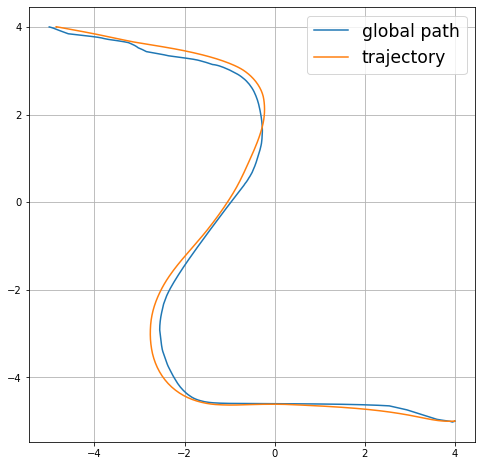

In [33]:
draw_paths(global_path, local_path)

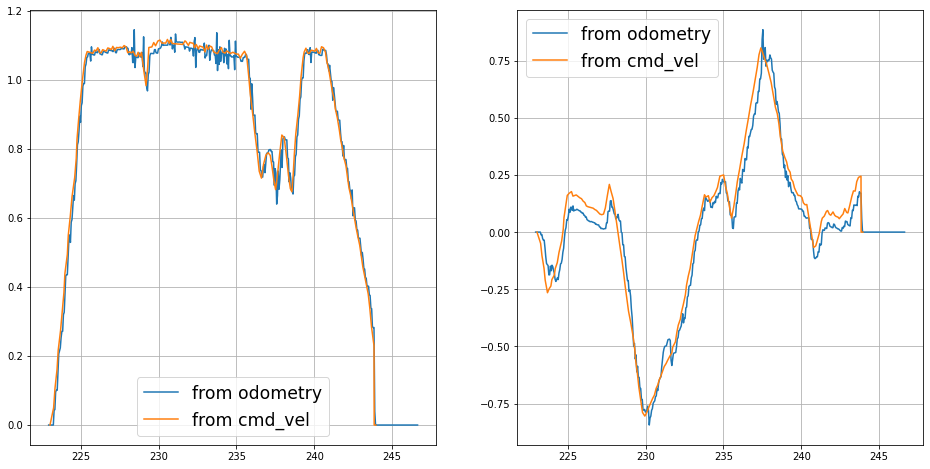

In [34]:
cmd_vel = pd.read_csv(bag.message_by_topic("/robot/cmd_vel"))
odom_vel = utils.odom_to_vel(local_path)
draw_vel(cmd_vel, odom_vel)

In [35]:
utils.travel_time(cmd_vel)

20.582000000000022

In [36]:
distance = utils.local_to_global_distance(
    local_path,
    global_path
)


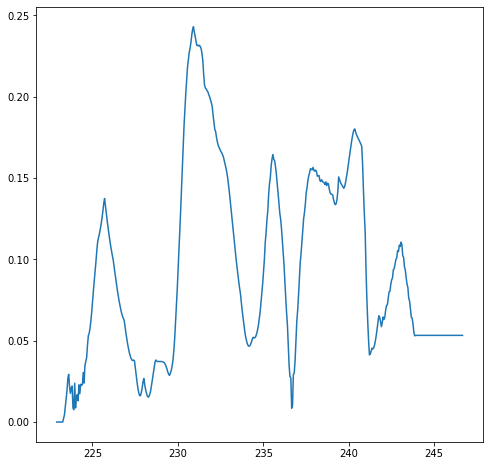

In [37]:

plt.figure(figsize=(8, 8))
plt.plot(distance.t, distance.dist)
plt.show()

In [38]:
route_deviation = utils.path_deviation(local_path, distance)
route_deviation

(2.216326450602641, 0.11712954995128497)

### Dump Data

In [39]:
import os
import json

dump_path = os.path.join("dumped_data", MAP)

if not os.path.exists(dump_path):
    os.makedirs(dump_path)

data = {
    "global_path": global_path.to_dict(),
    "local_path": local_path.to_dict(),
    "velocity": utils.simplify_cmd_vel(cmd_vel).to_dict(),
    "odom_velocity": odom_vel.to_dict(),
    "global_path_deviation": distance.to_dict(),
    "measured_deviation": {"absolute": route_deviation[0], "relative": route_deviation[1]},
    "travel_time": utils.travel_time(cmd_vel),
    "freq": bag.topic_table[bag.topic_table["Topics"]=="/robot/cmd_vel"].Frequency.iloc[0]
}

with open(os.path.join(dump_path, f"{APPROACH}.json"), "w") as f:
    json.dump(data, f)

